<a href="https://colab.research.google.com/github/gerlaxrex/Cat-Species-Classifier-with-XAI/blob/main/Cat_Species_Recognition_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import os, time, sys, gc
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.8.2


Load dataset

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! \cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d juliencalenge/felidae-tiger-lion-cheetah-leopard-puma
! unzip felidae-tiger-lion-cheetah-leopard-puma.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 90% 131M/145M [00:01<00:00, 121MB/s]
100% 145M/145M [00:01<00:00, 130MB/s]
Archive:  felidae-tiger-lion-cheetah-leopard-puma.zip
  inflating: Felidae/Cheetah/Cheetah_001.jpg  
  inflating: Felidae/Cheetah/Cheetah_002.jpg  
  inflating: Felidae/Cheetah/Cheetah_003.jpg  
  inflating: Felidae/Cheetah/Cheetah_004.jpg  
  inflating: Felidae/Cheetah/Cheetah_005.jpg  
  inflating: Felidae/Cheetah/Cheetah_006.jpg  
  inflating: Felidae/Cheetah/Cheetah_007.jpg  
  inflating: Felidae/Cheetah/Cheetah_008.jpg  
  inflating: Felidae/Cheetah/Cheetah_009.jpg  
  inflating: Felidae/Cheetah/Cheetah_010.jpg  
  inflating: Felidae/Cheetah/Cheetah_011.jpg  
  inflating: Felidae/Cheetah/Cheetah_012.jpg  
  inflating: Felidae/Cheetah/Cheetah_013.jpg  
  inflating: Felidae/Cheetah/Cheetah_014.jpg  
  inflating: Felidae/Cheetah/Cheetah_015.jpg  
  inflating: Felidae/Cheetah/Cheetah_016.jpg  
  inflating: Felida

Define the preprocessing functions

In [4]:
preprocessed_images = []
filenames = []
labels = []
img_dir = './Felidae'

# Model Variables

IMG_SHAPE = (256, 256)
CLASS_LIST = ['Cheetah', 'Leopard', 'Lion', 'Puma', 'Tiger']
CLASS_DICT = dict(zip(CLASS_LIST, range(len(CLASS_LIST))))
TO_CLASS_DICT = {v:k for k,v in CLASS_DICT.items()}

TRAIN_BS = 16
VALID_BS = 1
EPOCHS = 10

# Helper function for the examples
def preprocess_dataset(img_dir):
  for (root, dirs, files) in os.walk(img_dir):
    for file in files:
      img_path = os.path.join(root,file)
      filenames.append(img_path)
      preprocessed_images.append(decode_image(img_path))
      labels.append(retrieve_label(img_path))

def decode_image(img_path):
  with Image.open(img_path) as img:
    p_img = np.array(img.resize(IMG_SHAPE).convert('RGB'))
    return p_img

def retrieve_label(img_path):
  return CLASS_DICT[img_path.split('/')[-2]]

preprocess_dataset(img_dir)
#Train/Valid Stratified split
train_fnames, valid_fnames, train_labels, valid_labels = train_test_split(preprocessed_images, labels, train_size=0.8, stratify=labels)

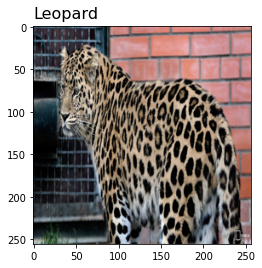

In [5]:
idx = 10

plt.text(0,-10,TO_CLASS_DICT[train_labels[idx]], size=16)
plt.imshow(train_fnames[idx])

In [6]:
def process_image(img_path):
  with Image.open(img_path.numpy()) as img:
    p_img = np.array(img.resize(IMG_SHAPE).convert('RGB'))
    return tf.convert_to_tensor(p_img)

def process_label(img_path):
  parts = tf.strings.split(img_path,'/')
  one_hot = parts[-2] == CLASS_LIST
  return tf.argmax(one_hot)

def build_dataset(images, labels, batch_size, shuffle=True, prefetch_size=1):
  #Build the single datasets
  tot_ds = tf.data.Dataset.from_tensor_slices((images,labels))
  # tot_ds = tot_ds.map(lambda x,l : (tf.py_function(process_image, [x], tf.uint8), l))
  #Transform into one and split in train/validation
  total_size = tot_ds.cardinality().numpy()
  #Shuffle, batch, optimize
  tot_ds = tot_ds.repeat()
  if shuffle:
    tot_ds = tot_ds.shuffle(total_size)
  tot_ds = tot_ds.batch(batch_size).prefetch(prefetch_size)
  return tot_ds, total_size

In [7]:
# train_ds, valid_ds, train_size, valid_size= build_datasets(preprocessed_images, labels)

In [8]:
train_ds, train_size = build_dataset(train_fnames, train_labels, TRAIN_BS)
valid_ds, valid_size = build_dataset(valid_fnames, valid_labels, VALID_BS, shuffle=False)

In [9]:
SPE_TRAIN = train_size//TRAIN_BS
SPE_VALID = valid_size//VALID_BS

Define the Data augmentation pipeline.

We will make pass all our data for this preprocessing pipeline (when not in `'training'` the operations will be disabled)

In [10]:
data_augmentation_pipeline = tf.keras.Sequential(layers=[tf.keras.layers.Rescaling(scale=1./255),
                                                  tf.keras.layers.RandomRotation(factor=0.2),
                                                  tf.keras.layers.RandomZoom(height_factor=0.1),
                                                  tf.keras.layers.RandomContrast(factor=0.1)], name='Preprocessing_Pipeline')

tf.Tensor(4, shape=(), dtype=int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


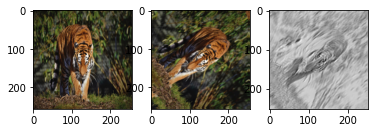

In [11]:
#Example
for (img, label) in valid_ds.take(1):
  fig, ax = plt.subplots(1,3)
  print(label[0])
  ax[0].imshow(img[0])
  processed_img = data_augmentation_pipeline(img[0], training=True)
  ax[1].imshow(processed_img)
  x = tf.keras.layers.Conv2D(5,kernel_size=(5,5))(tf.expand_dims(processed_img,0))
  ax[2].imshow(x[0,:,:,1],cmap='gray')
  plt.show()

Model definition

In [12]:
class PreprocessingLayer(tf.keras.layers.Layer):

  def __init__(self):
    super().__init__(name='Preprocessing_layer')
    self.rescale_layer = tf.keras.layers.Rescaling(scale=1./255)
    self.rotate_layer = tf.keras.layers.RandomRotation(factor=0.2)
    self.zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.2)
    self.contrast_layer = tf.keras.layers.RandomContrast(factor=0.2)

  def call(self, inputs, training=False):
    x = self.rescale_layer(inputs)
    x = self.rotate_layer(inputs, training=training)
    x = self.zoom_layer(x, training=training)
    x = self.contrast_layer(x, training=training)
    return x


class CatSpeciesClassifier(tf.keras.Model):

  def __init__(self, input_shape, num_classes):
    super().__init__(name='CatSpecies_Classifier')

    self.preprocessing_layer = PreprocessingLayer()

    self.vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)  
    self.vgg19.trainable = False 

    # Create the intermediate model
    self.vgg19_double_out = tf.keras.Model(inputs=[self.vgg19.inputs], outputs = [self.vgg19.get_layer(index=-2).output, self.vgg19.output])

    self.gap_layer = tf.keras.layers.GlobalAveragePooling2D()
    self.dense_layer = tf.keras.layers.Dense(units=256, activation='relu')
    self.prediction_layer = tf.keras.layers.Dense(num_classes)

  def call(self, inputs, training=False):
    # Preprocessing
    x = self.preprocessing_layer(inputs, training=training)
    # Convolutional Network
    last_conv_out, x = self.vgg19_double_out(x, training=training)
    # Prediction Network
    x = self.gap_layer(x) # 11x11x64 -> 1x1x64
    x = self.dense_layer(x)
    return self.prediction_layer(x), last_conv_out


  def train_step(self, data):
    x,y = data
    with tf.GradientTape() as tape:
      y_pred, _ = self(x, training=True)
      loss = self.compiled_loss(y, y_pred)
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    x,y = data
    y_pred, _ = self(x, training=False)
    loss = self.compiled_loss(y, y_pred)
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}  
    

In [13]:
cat_species_classifier = CatSpeciesClassifier(input_shape=IMG_SHAPE, num_classes=len(CLASS_DICT.keys()))

80150528/80134624 [==============================] - 0s 0us/step


In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
metrics_array = ['accuracy']

callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)]

cat_species_classifier.build(input_shape=(None,*IMG_SHAPE,3))
cat_species_classifier.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                               optimizer='adam',
                               metrics=metrics_array)

In [15]:
cat_species_classifier.summary()

Model: "CatSpecies_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Preprocessing_layer (Prepro  multiple                 0         
 cessingLayer)                                                   
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 model (Functional)          [(None, None, None, 512)  20024384  
                             , (None, None, None, 512            
                             )]                                  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               multiple        

In [16]:
cat_species_classifier.fit(train_ds, 
               epochs=EPOCHS, 
               steps_per_epoch=SPE_TRAIN,
               validation_data = valid_ds,
               validation_steps=SPE_VALID,
               callbacks = callbacks)

Epoch 1/10
12/12 [==============================] - 205s 17s/step - loss: 3.1280 - accuracy: 0.4427 - val_loss: 1.8833 - val_accuracy: 0.5918
Epoch 2/10
12/12 [==============================] - 200s 17s/step - loss: 1.0363 - accuracy: 0.6927 - val_loss: 0.9512 - val_accuracy: 0.7551
Epoch 3/10
12/12 [==============================] - 200s 17s/step - loss: 0.4112 - accuracy: 0.8333 - val_loss: 0.6529 - val_accuracy: 0.8163
Epoch 4/10
12/12 [==============================] - 200s 17s/step - loss: 0.2646 - accuracy: 0.9062 - val_loss: 0.9582 - val_accuracy: 0.7551
Epoch 5/10
12/12 [==============================] - 198s 17s/step - loss: 0.2062 - accuracy: 0.9271 - val_loss: 0.5701 - val_accuracy: 0.8367
Epoch 6/10
12/12 [==============================] - 200s 17s/step - loss: 0.1397 - accuracy: 0.9427 - val_loss: 0.5812 - val_accuracy: 0.7959
Epoch 7/10
12/12 [==============================] - 199s 17s/step - loss: 0.2040 - accuracy: 0.9427 - val_loss: 0.8207 - val_accuracy: 0.8367
Epoch 

In [17]:
cat_species_classifier.save('model_saving', save_format='tf')

INFO:tensorflow:Assets written to: model_saving/assets


INFO:tensorflow:Assets written to: model_saving/assets


--------------------
Real label is: Tiger
Predicted label is: {'Cheetah': 1.821236e-09, 'Leopard': 5.717961e-08, 'Lion': 1.6460411e-06, 'Puma': 2.278124e-09, 'Tiger': 0.99999833}
--------------------


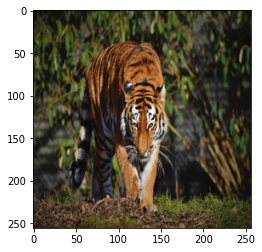

In [18]:
for img, label in valid_ds.take(1):
  print('--------------------')
  print(f'Real label is: {TO_CLASS_DICT[label.numpy()[0]]}')
  plt.imshow(tf.squeeze(img, 0))

  prediction, map = cat_species_classifier.predict(img)
  prediction = tf.nn.softmax(prediction).numpy().squeeze()
  prediction_prob = {k: prediction[idx] for idx,k in enumerate(CLASS_LIST)}


  print(f'Predicted label is: {prediction_prob}')
  print('--------------------')

In [19]:
def gradcam_heatmap(img, model, pred_index=None):
    with tf.GradientTape() as tape:
        preds, last_conv_layer_output = model(img, training=False)
        if pred_index is None:
            pred_index = tf.argmax(tf.nn.softmax(preds[0]))
        class_channel = tf.convert_to_tensor(preds[:, pred_index])

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

--------------------
Real label is: Leopard
Predicted label is: {'Cheetah': 8.076704e-06, 'Leopard': 0.9999919, 'Lion': 4.3832306e-16, 'Puma': 4.0627583e-16, 'Tiger': 1.3970975e-13}
--------------------


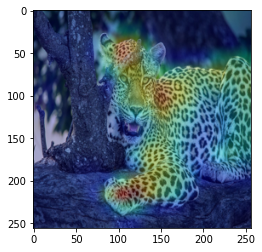

In [27]:
for img, label in valid_ds.skip(159).take(1):
  print('--------------------')
  print(f'Real label is: {TO_CLASS_DICT[label.numpy()[0]]}')

  prediction = tf.nn.softmax(cat_species_classifier.predict(img)[0]).numpy().squeeze()
  heatmap = gradcam_heatmap(img, cat_species_classifier)
  
  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize(IMG_SHAPE)
  plt.imshow(img.numpy().squeeze())
  plt.imshow(jet_heatmap, alpha = 0.3)
  

  prediction_prob = {k: prediction[idx] for idx,k in enumerate(CLASS_LIST)}

  print(f'Predicted label is: {prediction_prob}')
  print('--------------------')